In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tarfile as tf
import shutil
from fastai.vision import *
from fastai.vision.all import *
from fastai.vision.gan import *
from fastai.callback.all import *
from torchvision.utils import save_image
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "../input/butterfly/butterfly/"

In [4]:
bs = 128
size = 64
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))

In [5]:
dls = dblock.dataloaders(path, path=path, bs=bs)

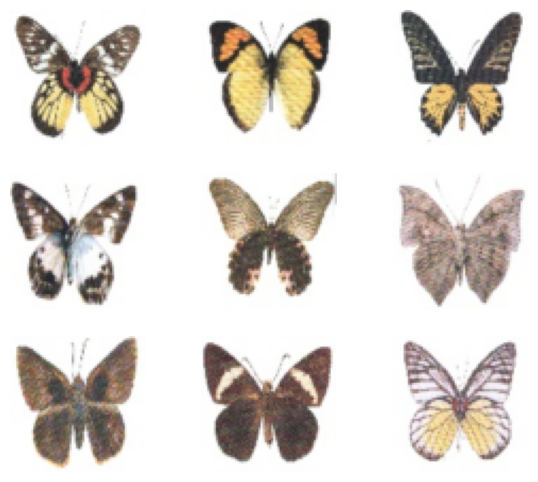

In [6]:
dls.show_batch(nrows=3, figsize=(7,6))

In [7]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [8]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

In [9]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [10]:
# learn.fit(50, 2e-4, wd=0.)
learn.fit(400,5e-4)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.449675,0.399699,-0.630295,00:18
1,-0.505199,0.454529,-0.768887,00:07
2,-0.526809,0.441494,-0.751626,00:07
3,-0.566233,0.453138,-0.866638,00:08
4,-0.459358,0.169140,-0.455672,00:07
5,-0.402817,0.143014,-0.442531,00:07
6,-0.364599,0.054179,-0.416042,00:07
7,-0.316992,0.320957,-0.420470,00:07
8,-0.300180,0.004620,-0.354402,00:07
9,-0.287915,0.190809,-0.416507,00:07


In [11]:
learn.gan_trainer.switch(gen_mode = True)

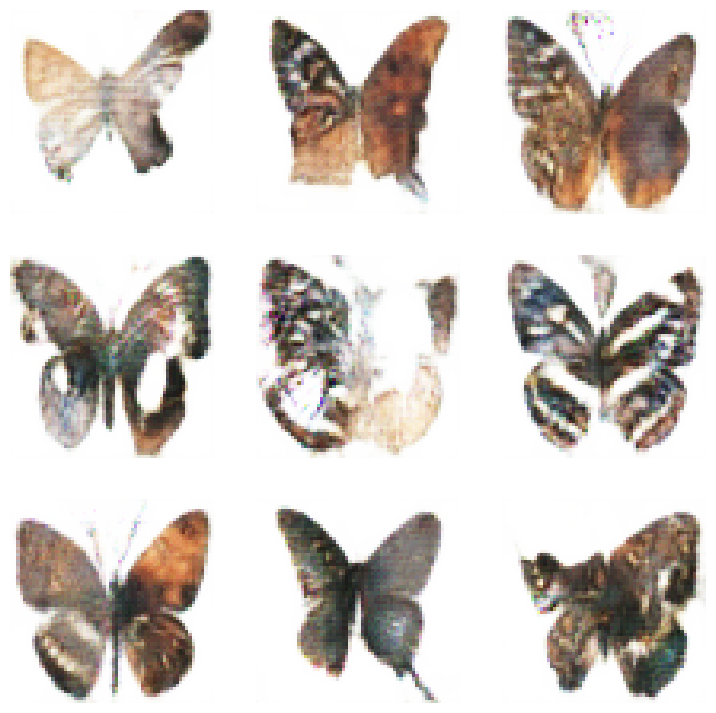

In [12]:
learn.show_results(max_n=9, ds_idx=0)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
else:
    shutil.rmtree('../output_images')
    os.mkdir('../output_images')

n_images = 128
gen_z = torch.randn(n_images, 100, device = device)
gen_images = generator(gen_z)
images = gen_images.to("cpu").clone().detach()
images = images.numpy().transpose(0, 2, 3, 1)
for i_image in range(gen_images.size(0)):
    save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'{i_image+1}.jpg'))

In [14]:
with tf.open('images.tgz', 'w:gz') as tar:
    tar.add('../output_images', arcname = os.path.basename('../output_images'))

In [15]:
# os.remove('images.tgz')
# shutil.rmtree('../output_images')